# Workflow + Figures

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import functions as func
import os


#Read in data from IMMAB4 model
gauss_coeffs = []
age = []

for i in range(1,301):

    file = '../models/IMMAB4/{}.out'.format(i)

    with open(file) as f:
        age.append(float(f.readline()))

    gauss_coeffs.append(np.genfromtxt(file, skip_header=1, usecols=(2,3)))

age = np.array(age)
gauss_coeffs = 1000*np.array(gauss_coeffs)
lmax_B = 4

ModuleNotFoundError: No module named 'shapely'

# Gauss Coefficients within model

In [2]:
for i in range(gauss_coeffs.shape[1]):

    plt.plot(age,gauss_coeffs[:,i,0],color=[0.5,0.5,0.5])
    plt.plot(age,gauss_coeffs[:,i,1],color=[0.5,0.5,0.5])

plt.plot(age,gauss_coeffs[:,0,0],'r')

plt.xlabel('Age / ka')
plt.ylabel('nT')
plt.title('Axial Dipole vs all other coefficients')
plt.show()

NameError: name 'gauss_coeffs' is not defined

# Optimised flows

In [4]:

if os.path.isfile('IMMAB4_roc.txt'):
    data = np.genfromtxt('IMMAB4_roc.txt',skip_header=1)
    age = data[:,0]
    results = data[:,1:]
else:
    print('IMMAB4_roc.txt does not exist, recalculating...')
      
    results = np.zeros((age.size,2))
    for i in range(age.size):

        print('Calculating age {:.1f}'.format(age[i]))

        dipole_rate, pol_ke, tor_ke = func.dipole_bound(lmax_B+1,lmax_B, gauss_coeffs[i,:,:], 13,
                                                      toroidal_only=False,save_files=False)

        results[i,0] = dipole_rate

        dipole_rate, pol_ke, tor_ke = func.dipole_bound(lmax_B+1,lmax_B, gauss_coeffs[i,:,:], 13,
                                                      toroidal_only=True, save_files=False)

        results[i,1] = dipole_rate

    np.savetxt('IMMAB4_roc.txt',np.hstack((age.reshape((len(age),1)),results)),header='age\tunconstrained\ttoroidal',delimiter='\t')

NameError: name 'os' is not defined

In [5]:
plt.plot(age,results[:,0],label='Unconstrained')
plt.plot(age,results[:,1],label='Toroidal only')

reversal_idx = int(np.arange(age.size)[np.abs(gauss_coeffs[:,0,0])==np.min(np.abs(gauss_coeffs[:,0,0]))])
plt.axvline(x=age[reversal_idx],color='k',label='g10 reversal')

plt.xlabel('Age / ka')
plt.ylabel('nT/yr')
plt.title('Axial Dipole optimised rate of change')
plt.legend(loc=0)
plt.show()

print('Rate at reversal age for unconstrained (toroidal) flow: {:.0f} ({:.0f}) nT/year  or  {:.0f} ({:.0f}) nT in 100 years'.format(float(results[reversal_idx,0]), float(results[reversal_idx,1]), float(100*results[reversal_idx,0]), float(100*results[reversal_idx,1])))

NameError: name 'age' is not defined

In [6]:
out = func.dipole_bound(lmax_B+1,lmax_B, gauss_coeffs[reversal_idx,:,:], 13, toroidal_only=False, save_files=True)

lat, lon = np.linspace(89,-89,100), np.linspace(0,360,200)
LON, LAT = np.meshgrid(lon,lat)
Br, Bth, Bph = func.evaluate_B(gauss_coeffs[reversal_idx,:,:], lat, lon)

print('Br (g10 = {:.1f}nT)'.format(gauss_coeffs[reversal_idx,0,0]))
ax = func.setup_map_figure()
im, cbar = func.plot_contourf(ax,LAT,LON,Br, 40, cmap='jet')
cbar.set_label('Br [nT]')
plt.show()

print('Flow (unconstrained)')
lons,lats,u,v = func.read_vectors()
ax = func.setup_map_figure()
im, cbar = func.plot_vectors(ax,lats,lons,u,v,density=3)
plt.show()

out = func.dipole_bound(lmax_B+1,lmax_B, gauss_coeffs[reversal_idx,:,:], 13, toroidal_only=True, save_files=True)

print('Flow (toroidal)')
lons,lats,u,v = func.read_vectors()
ax = func.setup_map_figure()
im, cbar = func.plot_vectors(ax,lats,lons,u,v,density=3)
plt.show()

NameError: name 'func' is not defined

## VGP records

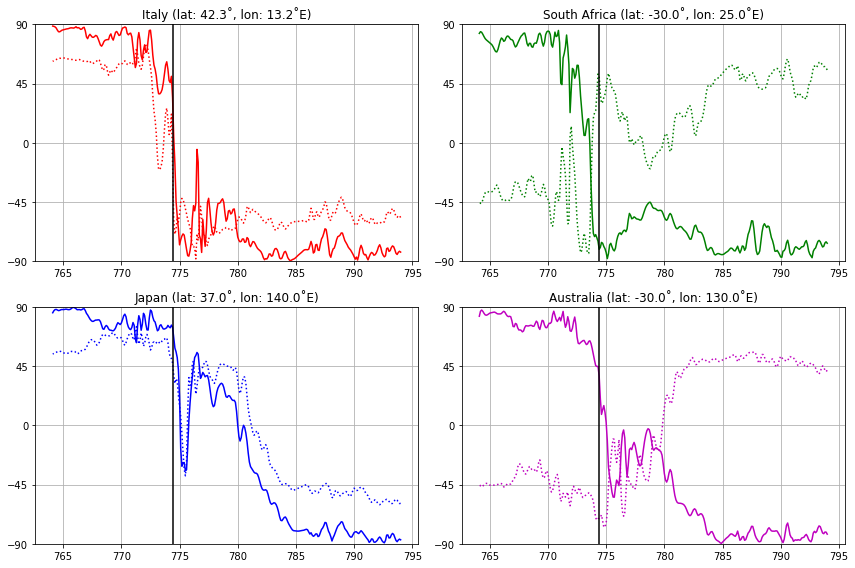

synthetic VGP records (solid) and synthetic inclinations (dashed)


In [7]:
#For specific sites, calculate VGP record

Italy = [42.3, 13.2]
SAfrica = [-30, 25]
Japan = [37,140]
Australia = [-30,130]

colours = ['r','g','b','m']
names = ['Italy', 'South Africa', 'Japan', 'Australia']
countries = [Italy,SAfrica,Japan,Australia]

#Add locations to names for the figure
names = [names[i]+' (lat: {:.1f}˚, lon: {:.1f}˚E)'.format(*countries[i]) for i in range(4)]

VGP_records = np.zeros((gauss_coeffs.shape[0],4))
inclinations = np.zeros((gauss_coeffs.shape[0],4))

#Iterate over all countries and over all time
plt.figure(figsize=(12,8))
for j in range(len(countries)):

    lat, lon = countries[j]

    for i in range(gauss_coeffs.shape[0]):

        #Evaluate B at location in space and time
        Br, Bth, Bph = func.evaluate_B(gauss_coeffs[i,:,:], lat, lon)

        #Calculate inclination, declination
        B_hor = np.sqrt(Bth**2 + Bph**2)

        f = (180/np.pi)
        inc = f*np.arctan(-Br/B_hor)
        dec = f*np.arctan2(Bph,-Bth)

        #Find VGP latitude
        m_lat = f*np.arctan(2/np.tan(inc/f))

        #Check for double solution of tangent function as the value cannot be negative
        if m_lat < 0:
            m_lat = m_lat + 180

        #Spherical law of cosines calculates the angular distance of the VGP from
        #the north pole (VGP colatitude)
        VGP = f*np.arccos(np.cos(m_lat/f)*np.cos((90-lat)/f) + np.sin((m_lat)/f)*np.sin((90-lat)/f)*np.cos(abs(dec/f)))

        VGP_records[i,j] = 90 - VGP #convert from co-lat to lat
        inclinations[i,j] = inc
        
    plt.subplot(2,2,j+1)
    plt.plot(age,VGP_records[:,j],color=colours[j])
    plt.plot(age,inclinations[:,j],color=colours[j], linestyle=':')
    plt.grid()

    plt.axvline(x=age[reversal_idx], color='k')

    plt.ylim([-90,90])
    plt.yticks([-90,-45,0,45,90])
    plt.title(names[j])


plt.tight_layout()
plt.show()
print('synthetic VGP records (solid) and synthetic inclinations (dashed)')

# Extrapolating to higher degrees

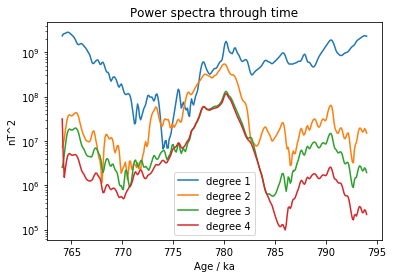

In [9]:
R = np.zeros((age.size,4))
for i in range(age.size):
    R[i,:] = func.power_spectra(4,gauss_coeffs[i,:])

for i in range(4):
    plt.plot(age,R[:,i],label='degree {}'.format(i+1))
plt.yscale('log')
plt.xlabel('Age / ka')
plt.ylabel('nT^2')
plt.title('Power spectra through time')
plt.legend(loc=0)
plt.show()

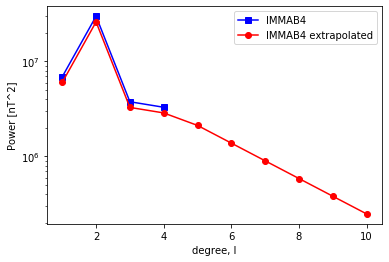

In [8]:
lmax, lmax_new = 4, 10
coeffs_ex = func.extrapolate_model(lmax, lmax_new, gauss_coeffs[reversal_idx,:,:])

R = func.power_spectra(4,gauss_coeffs[reversal_idx,:,:])
R_ex = func.power_spectra(10,coeffs_ex)

plt.plot(range(1,5),R,'bs-', label='IMMAB4')
plt.plot(range(1,11),R_ex,'ro-', label='IMMAB4 extrapolated')
plt.yscale('log')
plt.xlabel('degree, l')
plt.ylabel('Power [nT^2]')
plt.legend(loc=0)
plt.show()

Original model


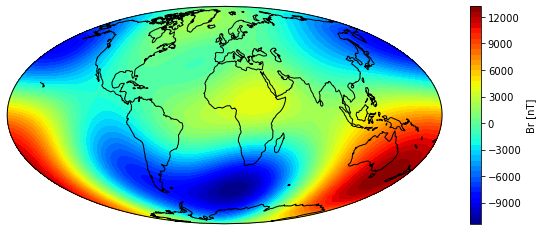

Extrapolated model


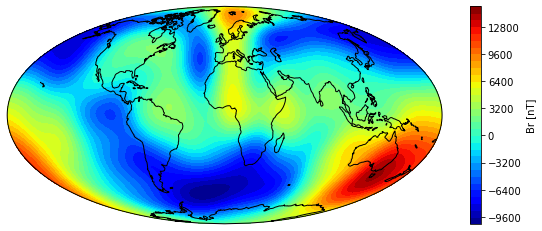

In [9]:

lat, lon = np.linspace(89,-89,100), np.linspace(0,360,200)
LON, LAT = np.meshgrid(lon,lat)


Br, Bth, Bph = func.evaluate_B(gauss_coeffs[reversal_idx,:,:], lat, lon)

print('Original model')
ax = func.setup_map_figure()
im, cbar = func.plot_contourf(ax,LAT,LON,Br, 40, cmap='jet')
cbar.set_label('Br [nT]')
plt.show()

Br, Bth, Bph = func.evaluate_B(coeffs_ex[:,:], lat, lon)

print('Extrapolated model')
ax = func.setup_map_figure()
im, cbar = func.plot_contourf(ax,LAT,LON,Br, 40, cmap='jet')
cbar.set_label('Br [nT]')
plt.show()


Calculating degree 10 (100.0%)

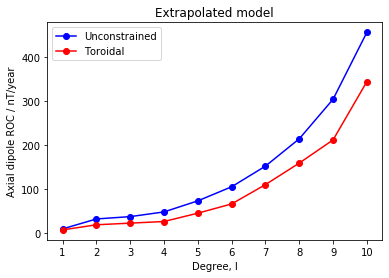

In [10]:
results = np.zeros((lmax_new,2))
for i in range(1,lmax_new+1):

    print('\rCalculating degree {:.0f} ({:.1f}%)'.format(i,100*i/lmax_new),end='',flush=True)

    dipole_rate, pol_ke, tor_ke = func.dipole_bound(lmax_new+1, i, coeffs_ex, 13,
                                                    toroidal_only=False,save_files=False)

    results[i-1,0] = dipole_rate

    dipole_rate, pol_ke, tor_ke = func.dipole_bound(lmax_new+1, i, coeffs_ex, 13,
                                                    toroidal_only=True, save_files=False)

    results[i-1,1] = dipole_rate

plt.plot(range(1,lmax_new+1), results[:,0], 'bo-', label='Unconstrained')
plt.plot(range(1,lmax_new+1), results[:,1], 'ro-', label='Toroidal')
plt.xlabel('Degree, l')
plt.xticks(range(1,lmax_new+1))
plt.ylabel('Axial dipole ROC / nT/year')
plt.title('Extrapolated model')
plt.legend(loc=0)
plt.show()

In [11]:
if os.path.isfile('IMMAB4_roc_ex.txt'):
    data = np.genfromtxt('IMMAB4_roc_ex.txt',skip_header=1)
    age = data[:,0]
    results = data[:,1:]
else:
    print('IMMAB4_roc_ex.txt does not exist, recalculating...')
      
    lmax = 4
    lmax_new = 10
    results = np.zeros((age.size,2))
    for i in range(age.size):

        print('\rCalculating age {:.1f} ({:.1f}%)'.format(age[i],100*(i+1)/len(age)),end='',flush=True)

        model = func.extrapolate_model(lmax,lmax_new,gauss_coeffs[i,:,:])
        dipole_rate, pol_ke, tor_ke = func.dipole_bound(lmax_new+1,lmax_new, model, 13,
                                                      toroidal_only=False,save_files=False)

        results[i,0] = dipole_rate

        dipole_rate, pol_ke, tor_ke = func.dipole_bound(lmax_new+1,lmax_new, model, 13,
                                                      toroidal_only=True, save_files=False)

        results[i,1] = dipole_rate

    np.savetxt('IMMAB4_roc_ex.txt',np.hstack((age.reshape((len(age),1)),results)),header='age\tunconstrained\ttoroidal',delimiter='\t')



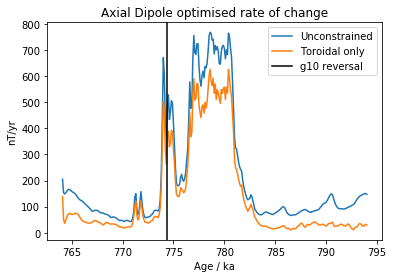

Rate at reversal age for unconstrained (toroidal) flow: 476 (371) nT/year  or  47590 (37145) nT in 100 years


In [12]:
plt.plot(age,results[:,0],label='Unconstrained')
plt.plot(age,results[:,1],label='Toroidal only')

reversal_idx = int(np.arange(age.size)[np.abs(gauss_coeffs[:,0,0])==np.min(np.abs(gauss_coeffs[:,0,0]))])
plt.axvline(x=age[reversal_idx],color='k',label='g10 reversal')

plt.xlabel('Age / ka')
plt.ylabel('nT/yr')
plt.title('Axial Dipole optimised rate of change')
plt.legend(loc=0)
plt.show()

print('Rate at reversal age for unconstrained (toroidal) flow: {:.0f} ({:.0f}) nT/year  or  {:.0f} ({:.0f}) nT in 100 years'.format(float(results[reversal_idx,0]), float(results[reversal_idx,1]), float(100*results[reversal_idx,0]), float(100*results[reversal_idx,1])))